In [1]:
#!pip install shap

In [3]:
import shap

D:\anaconda3\envs\dcaesr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]


D:\anaconda3\envs\dcaesr\lib\site-packages\torch\serialization.py:1525: UserWarning: This figure was saved with matplotlib version 3.7.1 and is unlikely to function correctly.
  result = unpickler.load()


768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]


{'denoising_hr': VAE1d_SR_multimodal(
   (encoder): Encoder1d(
     (encoder): Sequential(
       (0): EncoderBlock1d(
         (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
         (activation_in): Tanh()
         (dropout_in): Dropout(p=0.1, inplace=False)
         (conv1d_out): Conv1d(12, 192, kernel_size=(3,), stride=(1,))
         (activation_out): Tanh()
         (dropout_out): Dropout(p=0.1, inplace=False)
       )
       (1): EncoderBlock1d(
         (conv1d_in): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
         (activation_in): Tanh()
         (dropout_in): Dropout(p=0.1, inplace=False)
         (conv1d_out): Conv1d(384, 768, kernel_size=(3,), stride=(1,))
         (activation_out): Tanh()
         (dropout_out): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (decoder): Decoder1d(
     (decoder): Sequential(
       (0): DecoderBlock1d(
         (conv1d_in): ConvTranspose1d(768, 768, kernel_size=(3,), stride=(1,))
         (activation_in): Tanh()
   

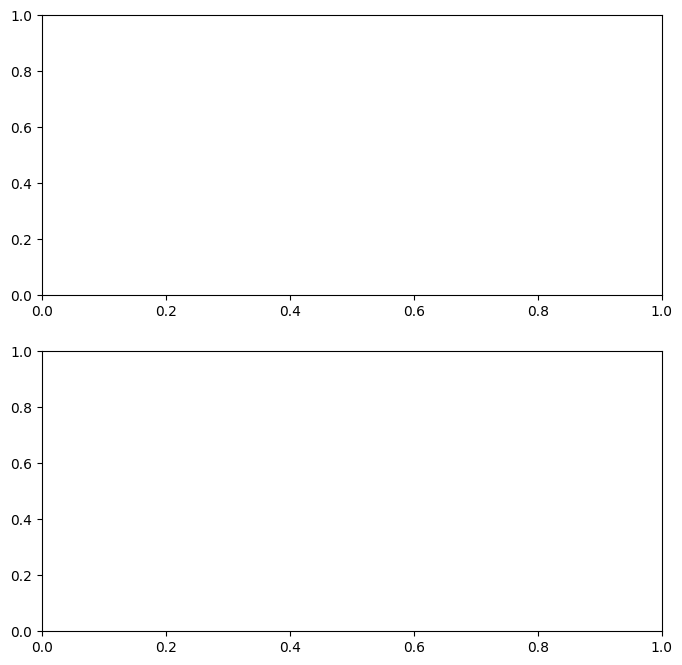

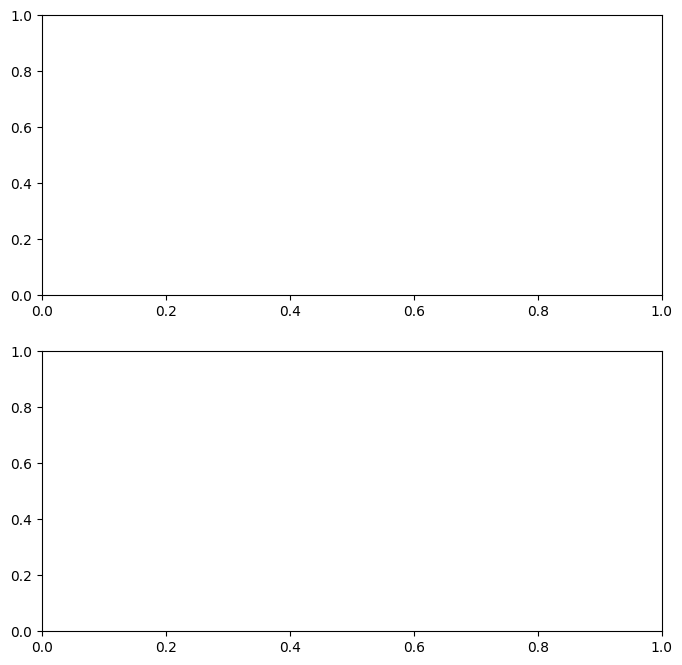

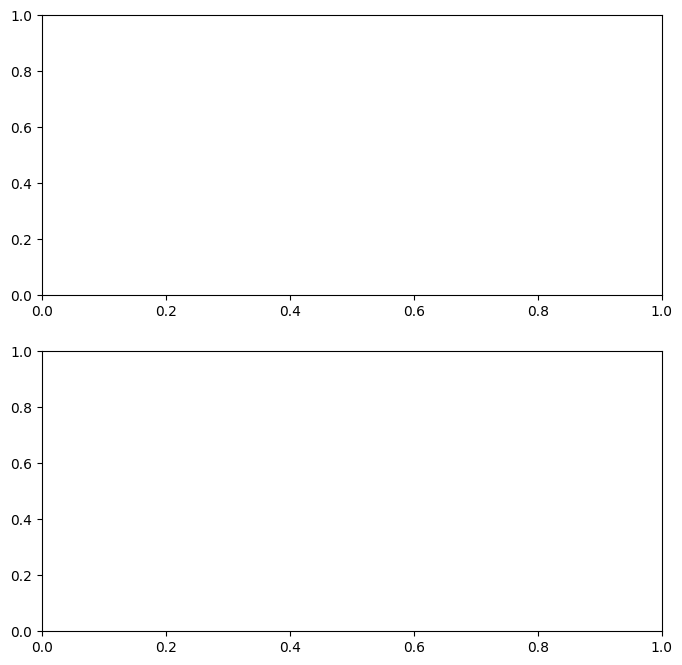

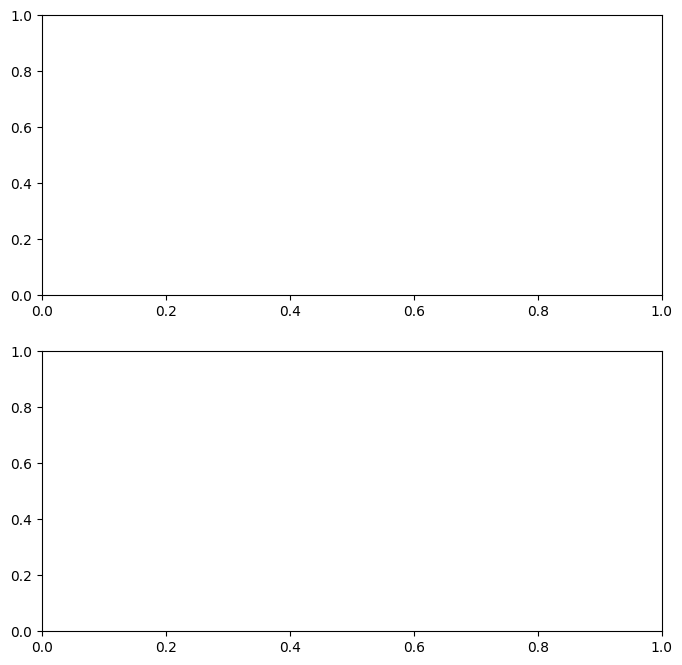

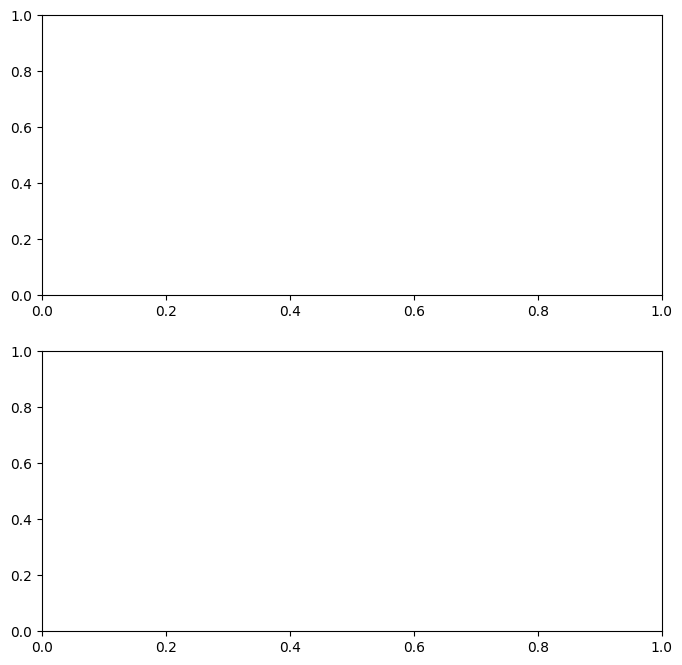

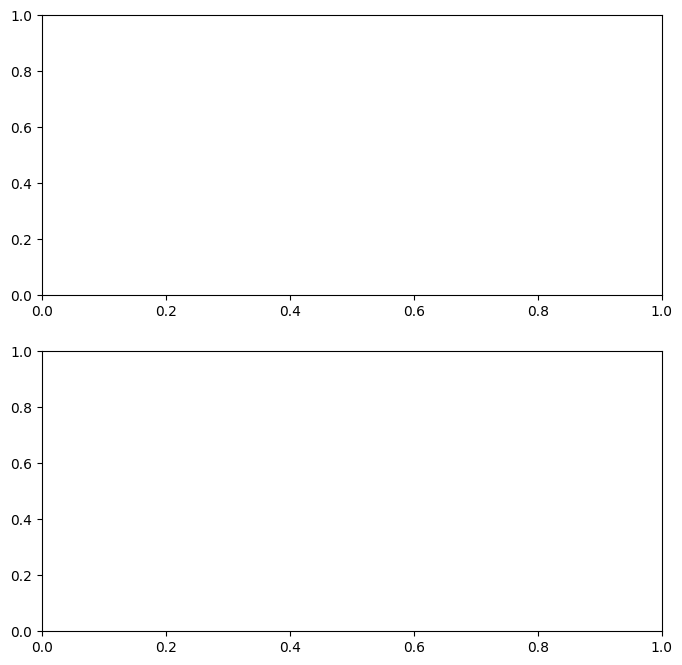

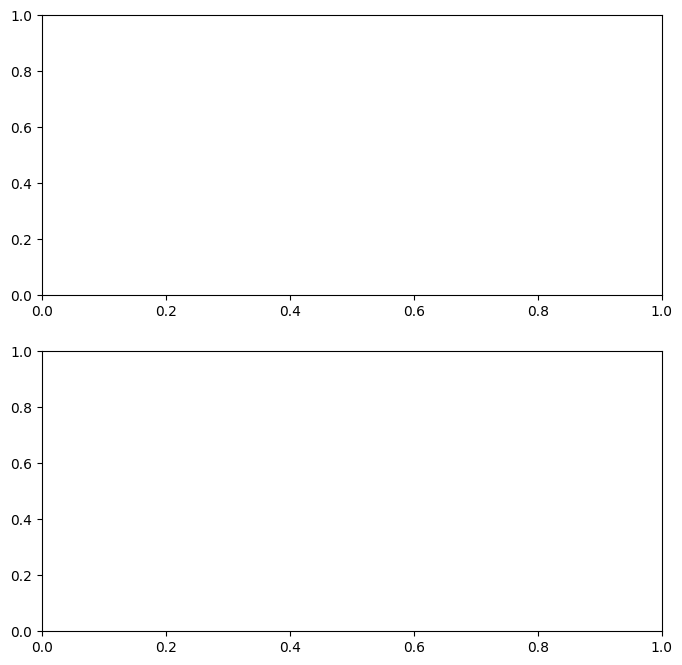

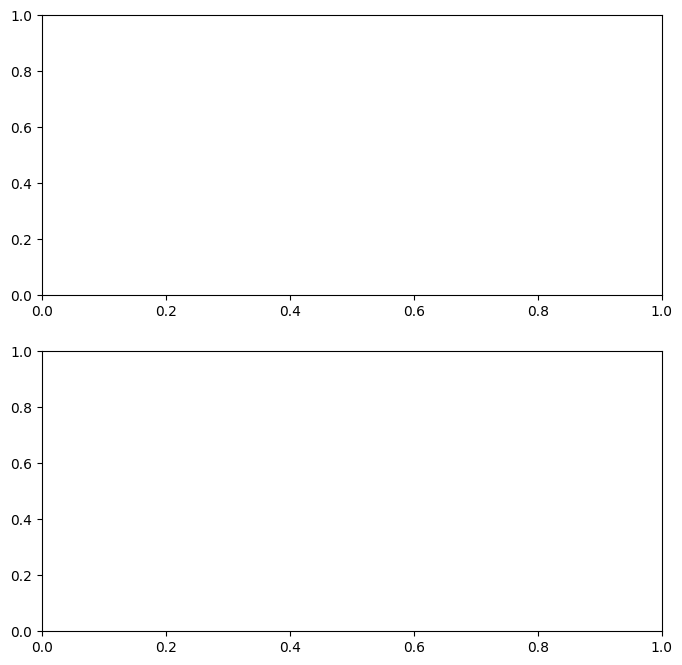

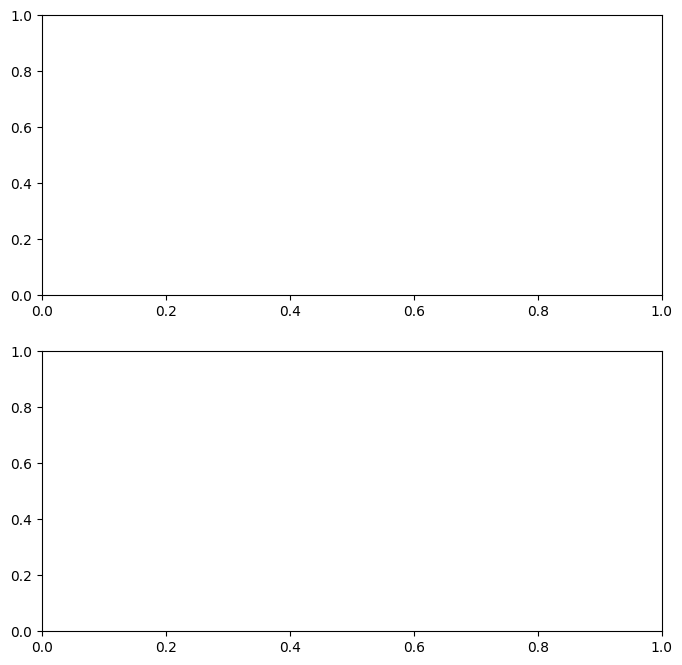

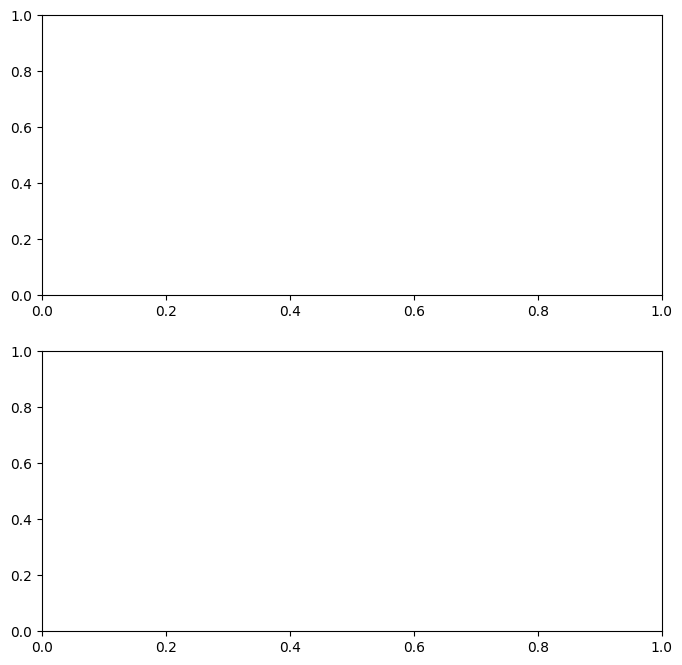

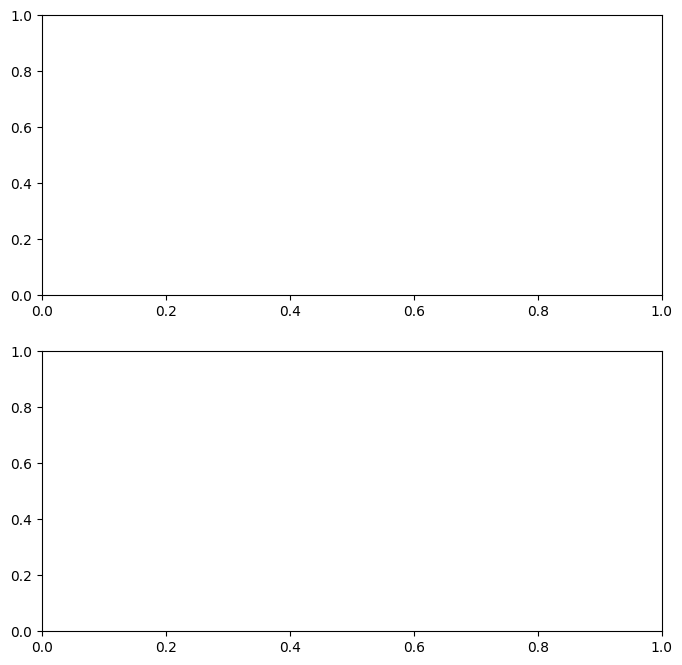

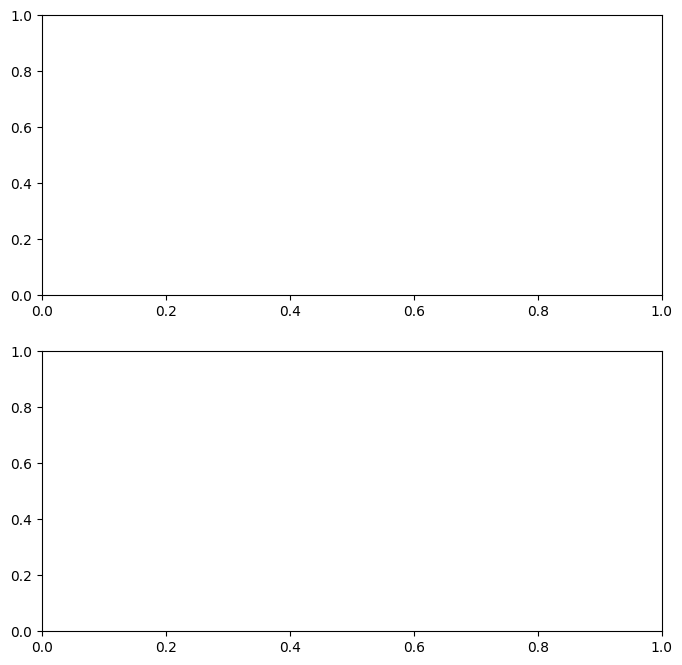

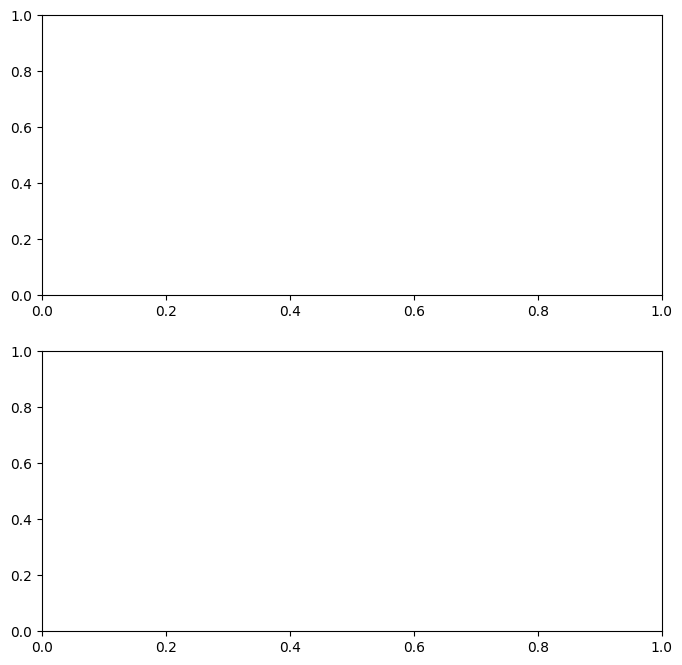

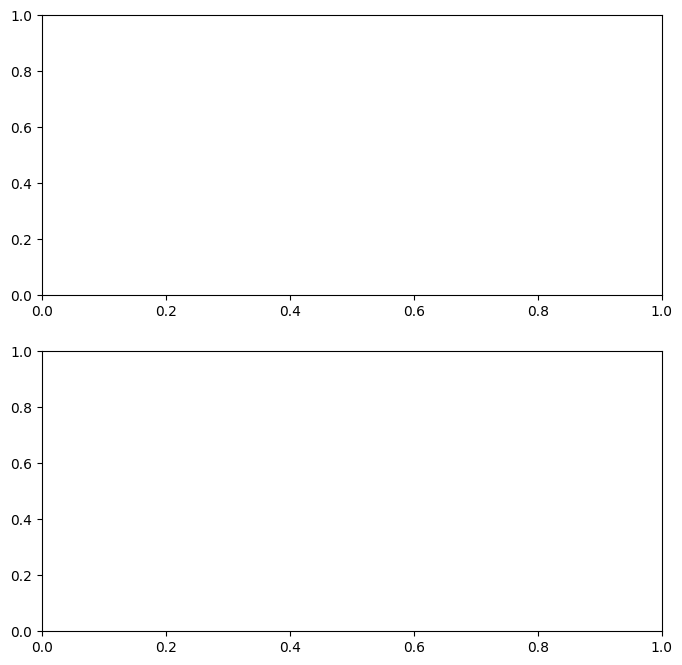

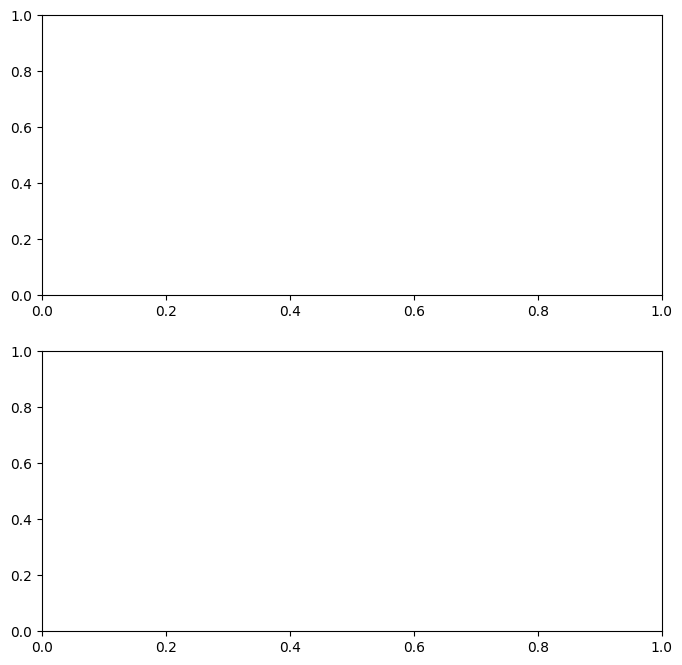

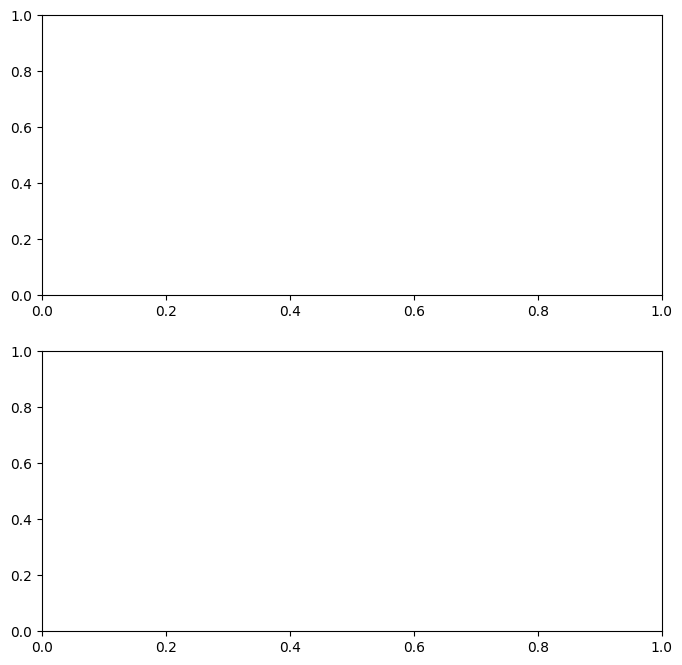

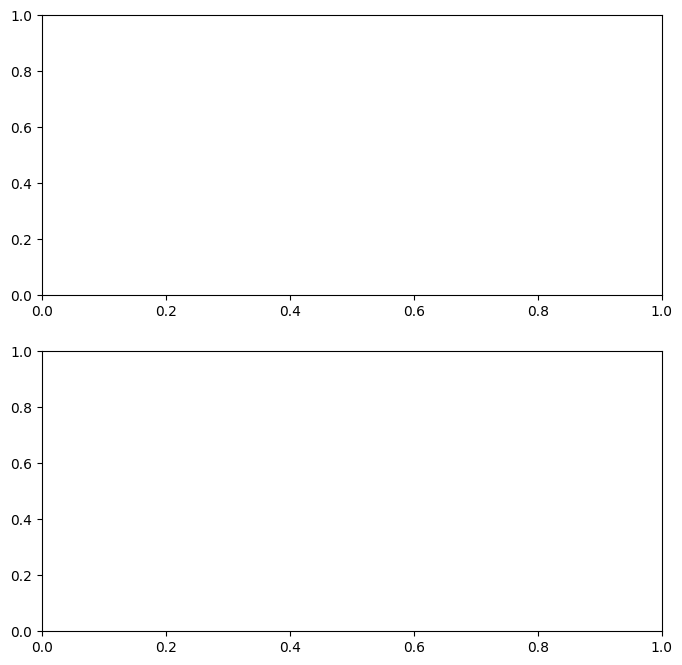

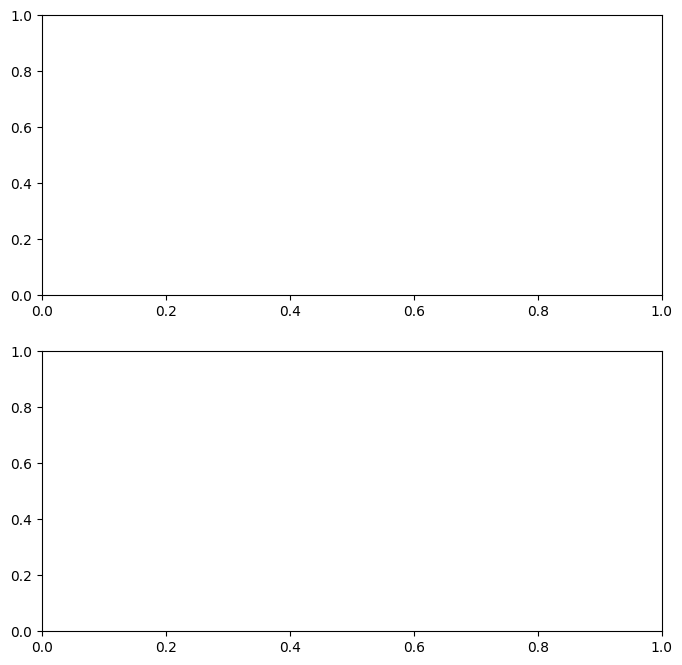

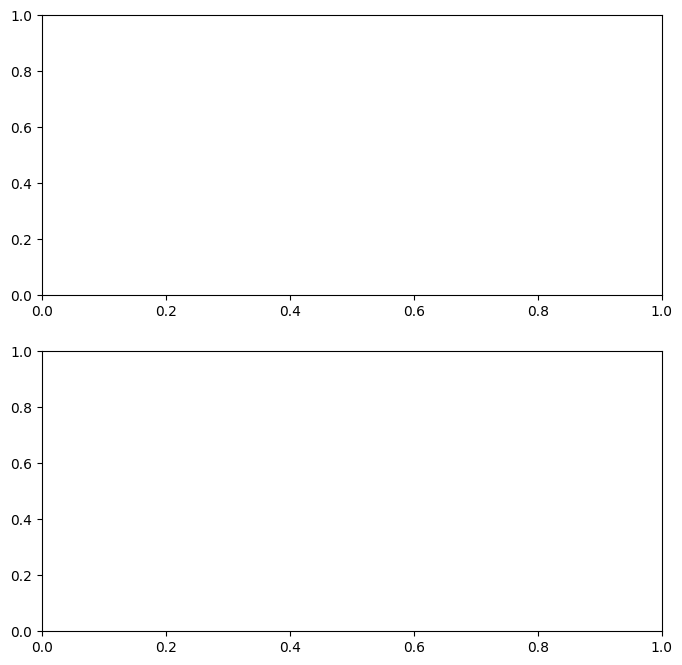

In [4]:
from functions import * 

models, _= load_models()
models

In [8]:
models.keys()

dict_keys(['denoising_hr', 'denoising_lrhr', 'denoising_lrhr_v2', 'denoising_nosr', 'nodenoising', 'nodenoising_nosr'])

In [10]:
labels = ["MI", "STTC", "CD", "HYP", "NORM"]

In [12]:
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_test_lr_n = {}
dict_windows_train_lr_n = {}
dict_windows_train_hr = {}
path = os.getcwd()+os.sep+"pt_data"+os.sep

for label in labels:

    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data
    
    
    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data
    
    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

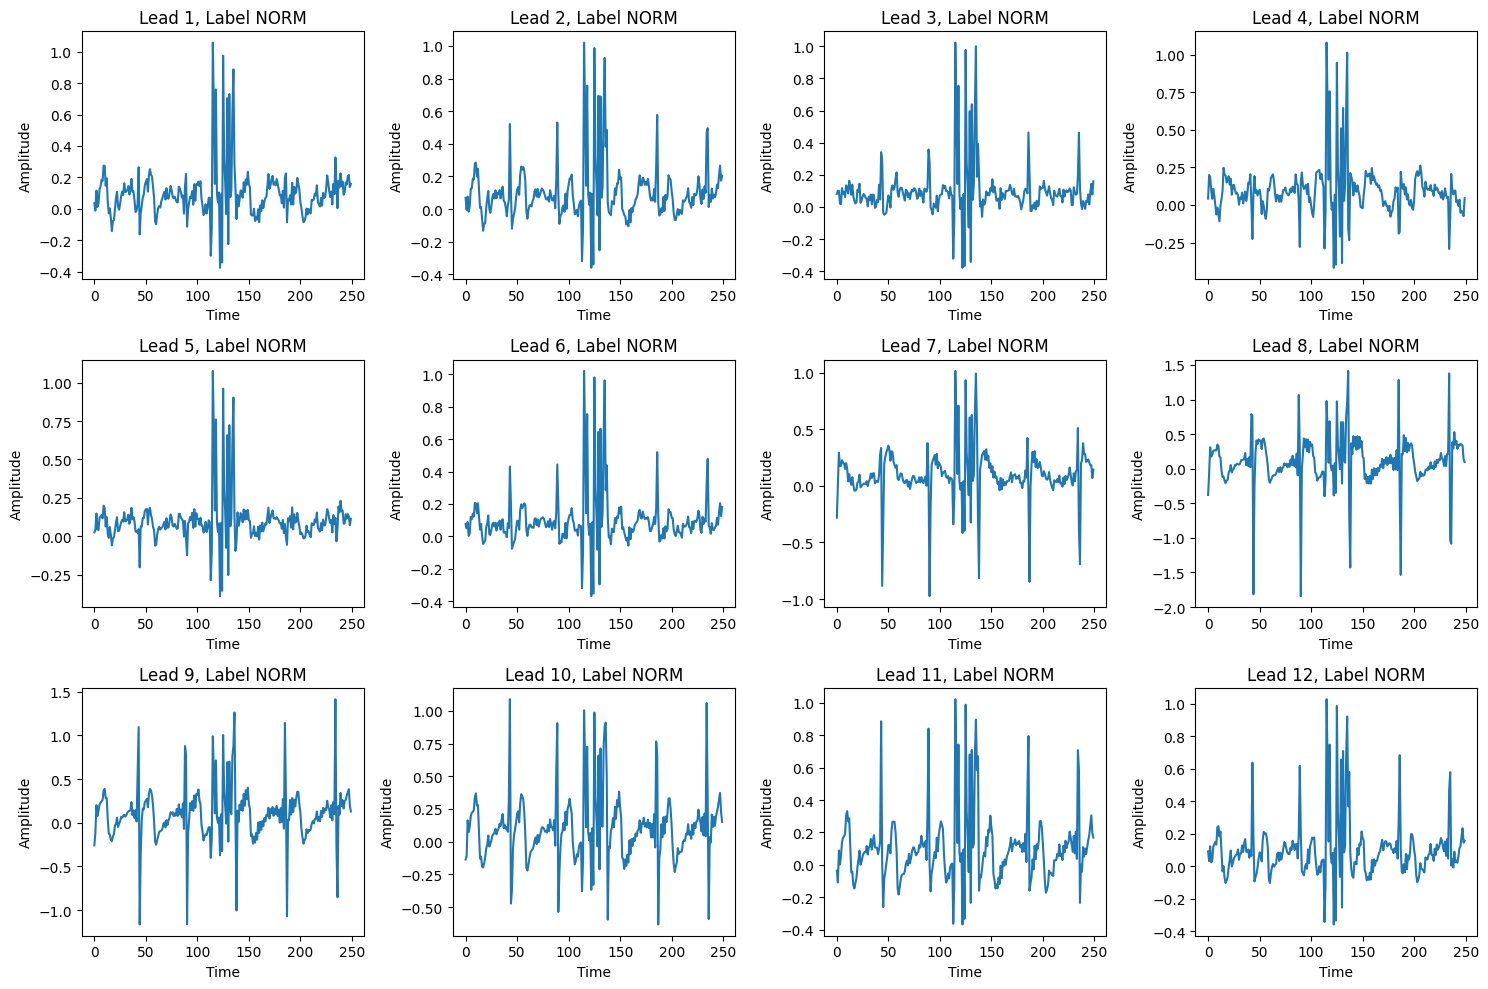

In [13]:
label = "NORM"
idx = 0
signal_lr = dict_windows_test_lr_n[label][idx]
signal_hr = dict_windows_test_hr[label][idx]
# Set up the figure with 12 subplots, 3 rows and 4 columns
fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows and 4 columns for 12 leads

batch_data = signal_lr[0, :, :].cpu().detach().numpy()
# Plot each lead in a subplot
for i in range(12):
    row, col = divmod(i, 4)  # Determine the row and column in the grid
    axs[row, col].plot(batch_data[i, :])  # Plot the i-th lead's data
    axs[row, col].set_title(f'Lead {i+1}, Label {label}')  # Set title for each subplot
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Amplitude')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

denoising_hr
denoising_lrhr
denoising_lrhr_v2
denoising_nosr
nodenoising
nodenoising_nosr


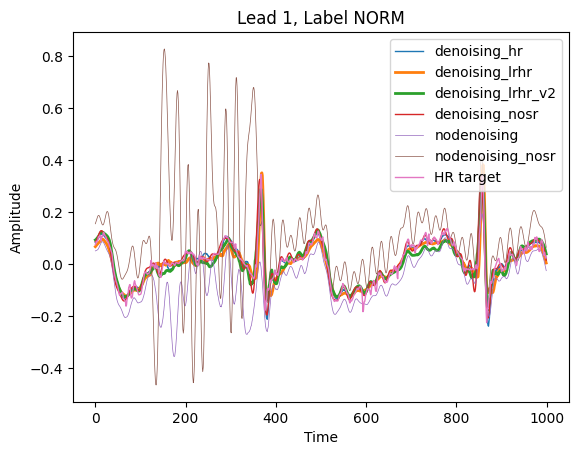

In [22]:
# Set up the figure with 12 subplots, 3 rows and 4 columns
label = "NORM"
idx = 0
signal_lr = dict_windows_test_lr_n[label][idx]
signal_hr = dict_windows_test_hr[label][idx]

ch = 0

if ch is None:
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows and 4 columns for 12 leads
else:
    fig = plt.figure()
    
for modelname, model in models.items():
    print(modelname)
    model.eval()
    model.to(device)
    signal_rec, signal_sr, _, _ = model([signal_lr, None, None, None])

    if signal_sr is not None:
        signal_sr = signal_sr.cpu().detach().numpy()
    else:
        signal_rec = torch.unsqueeze(signal_rec, dim = 0).cpu().detach().numpy()
        signal_sr = resample(signal_rec, size = 2500)
        signal_sr = signal_sr[0]

    if ch is None:
        # Plot each lead in a subplot
        for i in range(12):
            row, col = divmod(i, 4)  # Determine the row and column in the grid
            axs[row, col].plot(signal_sr[i, 1000:2000], label = modelname)  # Plot the i-th lead's data
            axs[row, col].set_title(f'Lead {i+1}, Label {label}')  # Set title for each subplot
            axs[row, col].set_xlabel('Time')
            axs[row, col].set_ylabel('Amplitude')
    else:
        if "nodenoising" in modelname:
            linewidth = 0.5
        elif "denoising_lrhr" in modelname:
            linewidth = 2
        else:
            linewidth = 1
        plt.plot(signal_sr[ch, 1000:2000], label = modelname, linewidth = linewidth)  

if ch is None:
    # Adjust layout to prevent overlap
    plt.tight_layout()
else:
    plt.plot(signal_hr[0, ch, 1000:2000].cpu().detach().numpy(), label = "HR target", linewidth = 1)  
    plt.title(f'Lead {ch+1}, Label {label}')  # Set title for each subplot
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.legend()    
plt.show()
fig.savefig("ablated_visualization.png", dpi = 600)

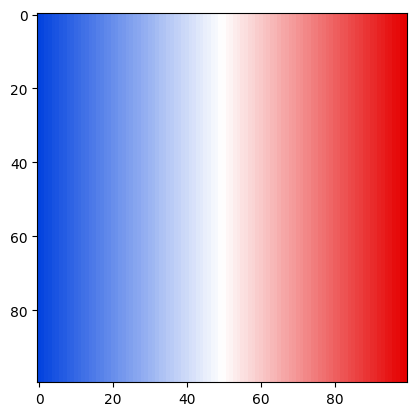

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

colors = ["xkcd:Blue", "White", "xkcd:Red"]
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=150)
mat = np.indices((100,100))[1]
plt.imshow(mat, cmap=cm)
plt.show()

In [26]:
len(models.keys()), models.keys()

(6,
 dict_keys(['denoising_hr', 'denoising_lrhr', 'denoising_lrhr_v2', 'denoising_nosr', 'nodenoising', 'nodenoising_nosr']))

In [27]:
from scipy import interpolate

def interpolate_sr(signals, fs_lr=50, fs_hr = 500, nchs=12, mode = 'cubic'):
    # Interpolation to 500 Hz
    t_low_res = np.arange(0, 5, 1/fs_lr)
    t_high_res = np.arange(0, 5, 1/fs_hr)  # 500 Hz sampling rate
    signals_sr = []
    for signal in signals:

        f_interp = interpolate.interp1d(t_low_res, signal, kind=mode, fill_value="extrapolate")
        signal_sr = f_interp(t_high_res)
        if isinstance(signal_sr, (np.ndarray, np.generic) ):
            signal_sr = torch.from_numpy(signal_sr)
        signals_sr.append(signal_sr)
    signals_sr = torch.stack(signals_sr)
    return signals_sr

In [28]:
def normalize_ecg(ecg, nchs = 12, div = 3):
  ecg_t = []
  for ch in range(nchs):
    print("\r", ch+1, "/", nchs, end = "")
    ecg_t.append(ecg[ch, :]/div)
  ecg_t = np.array(ecg_t)
  return ecg_t

In [29]:
models.keys()

dict_keys(['denoising_hr', 'denoising_lrhr', 'denoising_lrhr_v2', 'denoising_nosr', 'nodenoising', 'nodenoising_nosr'])

 12 / 12

C:\Users\Utente\AppData\Local\Temp\ipykernel_36600\419259877.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


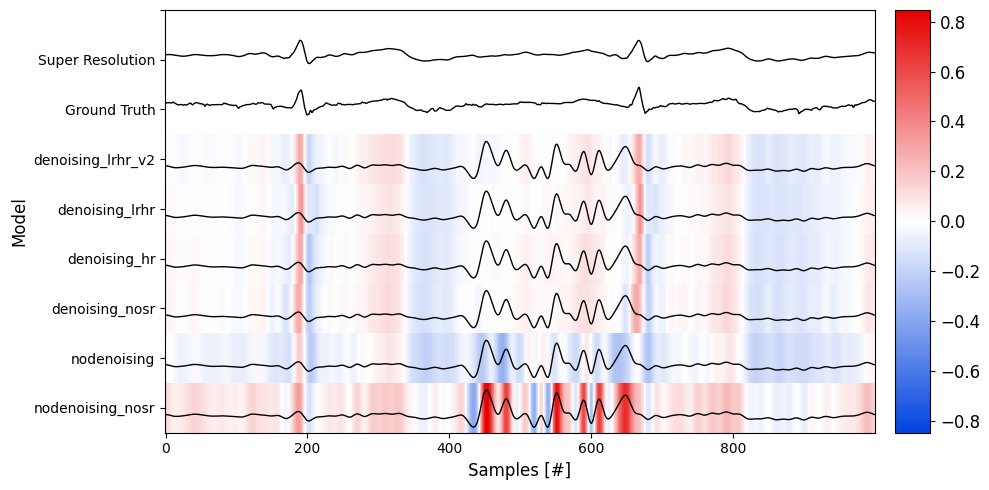

In [152]:
ch = 0
label = "NORM"
idx = 0
lr_data = dict_windows_test_lr_n[label][idx]
hr_data = dict_windows_test_hr[label][idx]
hr_data = torch.squeeze(hr_data, dim = 0).cpu().detach().numpy()

off = -0.2

fig, axs = plt.subplots(figsize = (10, 5))

activations = []
modelnames = ["nodenoising_nosr", "nodenoising", "denoising_nosr", "denoising_hr", "denoising_lrhr", "denoising_lrhr_v2"]

for modelname in modelnames:

  model = models[modelname]
  pred = model([lr_data, None, None, None])
  sr = pred[1]
  if modelname == "denoising_lrhr_v2":
      sr_data = sr.cpu().detach().numpy()
  rec = pred[0]

  activation = model.encoder.get_activations(lr_data, 0)
  activation = model.encoder.get_activations(activation, 1)

  if "nosr" in modelname:
      activation = model.decoder.get_activations(activation, 0)
      activation = model.decoder.get_activations(activation, 1)
      activation = interpolate_sr(activation.cpu().detach().numpy())
  else:
      activation = model.upsample.get_activations(activation, 0)
      activation = model.upsample.get_activations(activation, 1)

  activation = torch.squeeze(activation, dim = 0)
  #plt.rcParams["figure.autolayout"] = True

  lr_data_s = torch.squeeze(lr_data, dim = 0).cpu().detach().numpy()
  lr_data_s = interpolate_sr(lr_data_s)
  lr_data_s = normalize_ecg(lr_data_s, div = 2.0)
    
  axs.plot(lr_data_s[ch, 700:1700]+off, color = "k", linewidth = 1)

  activation = torch.unsqueeze(activation[ch, 700:1700], dim = 0)
  activation = activation.cpu().detach().numpy()
  activations.append(activation)
  off += 1.0

axs.plot(hr_data[ch, 700:1700]+off+0.3, color = "k", linewidth = 1)
axs.plot(sr_data[ch, 700:1700]+off+1.0+0.3, color = "k", linewidth = 1)

activations = np.vstack(activations)    
im = axs.imshow(activations, cmap = cm, norm=matplotlib.colors.CenteredNorm(), interpolation = "none", aspect = "auto", origin="lower"  ) 
modelnames.append("Ground Truth")
modelnames.append("Super Resolution")
modelnames.append("")
axs.set_yticks(np.arange(0, len(modelnames), 1))
axs.set_yticklabels(modelnames)#(np.arange(1, nchs+1, 1))

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%',  pad=0.2)
cbar = fig.colorbar(im, cax = cax, orientation='vertical')

axs.tick_params(axis='both', labelsize=10)
axs.set_xlabel("Samples [#]", fontsize=12)
axs.set_ylabel("Model", fontsize=12)
  
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(12)
    t.set_weight("normal")

      
fig.show()
plt.tight_layout()
fig.savefig("activationmap_ablations_emg.png".format(label), dpi = 600)

In [80]:
activations.shape

(6, 1000)

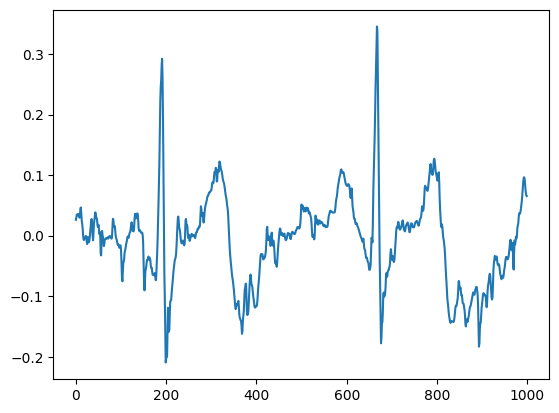

In [422]:
plt.plot(hr_data[ch, 700:1700])

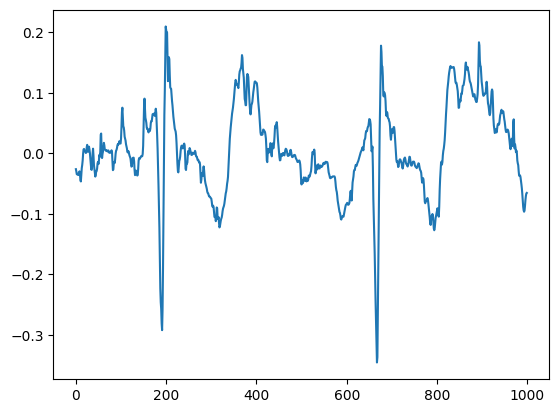

In [424]:
plt.plot(np.negative(hr_data[ch, 700:1700]))

 12 / 12

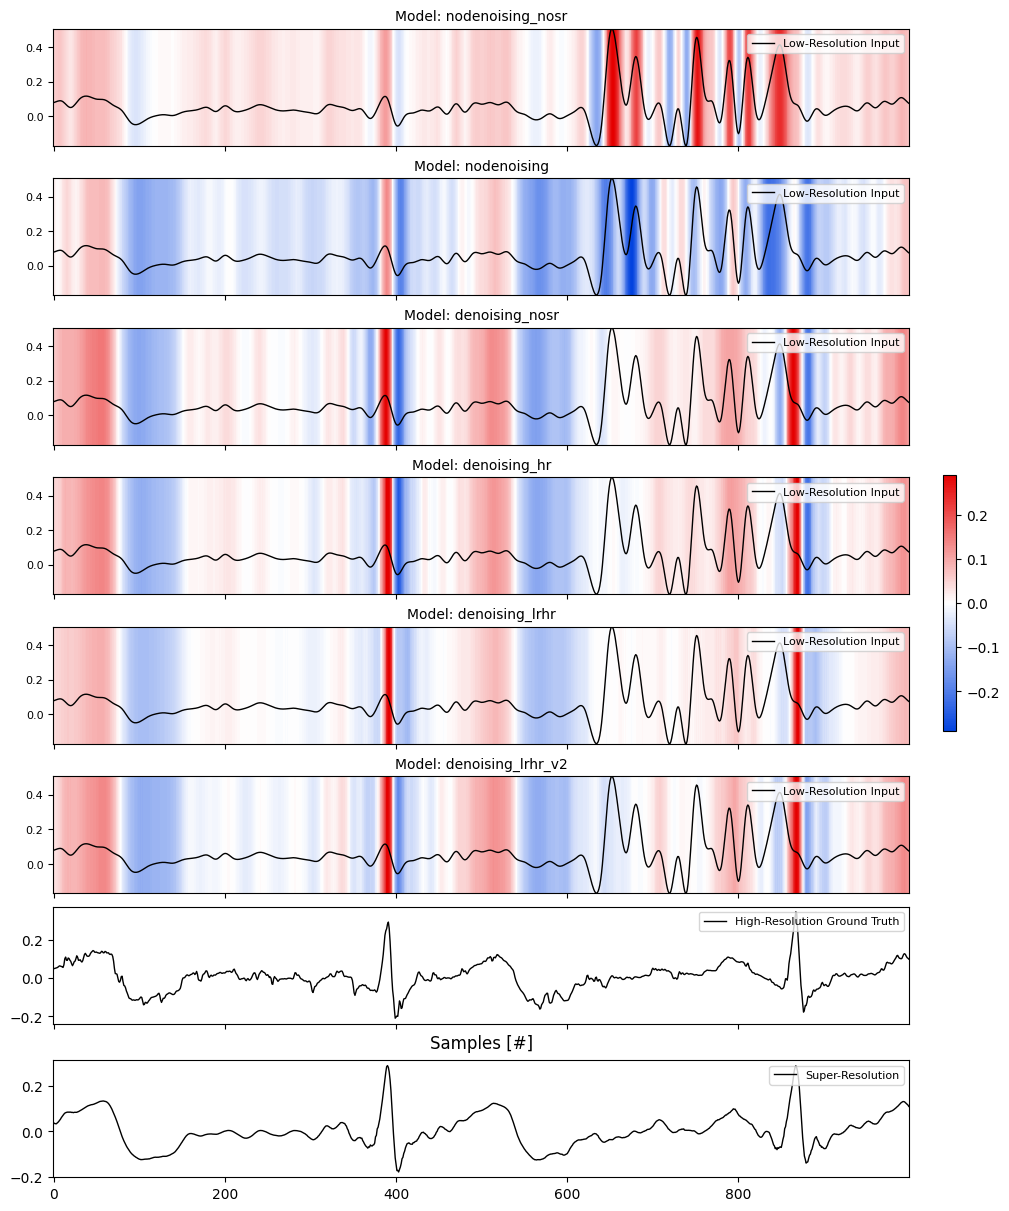

In [146]:
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# Number of models
num_models = len(modelnames)

# Create a figure with a row for each model
fig, axs = plt.subplots(nrows=num_models+2, figsize=(10, 2 * num_models), sharex=True, constrained_layout=True)

# Store activations for the colorbar range calculation
activations_all_models = []
modelnames = ["nodenoising_nosr", "nodenoising", "denoising_nosr", "denoising_hr", "denoising_lrhr", "denoising_lrhr_v2"]

hr_data = dict_windows_test_hr[label][idx]
hr_data = torch.squeeze(hr_data, dim = 0).cpu().detach().numpy()

for i, modelname in enumerate(modelnames):
    
    model = models[modelname]
    pred = model([lr_data, None, None, None])
    sr = pred[1]
    rec = pred[0]
    if modelname == "denoising_lrhr_v2":
      sr_data = sr.cpu().detach().numpy()
    # Get activations for this model
    activation = model.encoder.get_activations(lr_data, 0)
    activation = model.encoder.get_activations(activation, 1)

    if "nosr" in modelname:
        activation = model.decoder.get_activations(activation, 0)
        activation = model.decoder.get_activations(activation, 1)
        activation = interpolate_sr(activation.cpu().detach().numpy())
    else:
        activation = model.upsample.get_activations(activation, 0)
        activation = model.upsample.get_activations(activation, 1)

    # Process activation for plotting
    activation = torch.squeeze(activation, dim=0).cpu().detach().numpy()
    activation_section = activation[ch, 500:1500]
    activations_all_models.append(activation_section)

    # Low-resolution data processing for the model
    lr_data_s = torch.squeeze(lr_data, dim=0).cpu().detach().numpy()
    lr_data_s = interpolate_sr(lr_data_s)
    lr_data_s = normalize_ecg(lr_data_s, div = 2.2)
    # Plot low-resolution data
    axs[i].plot(lr_data_s[ch, 500:1500], color="k", linewidth=1, label="Low-Resolution Input")

    # Plot the activation map for this model
    #divider = make_axes_locatable(axs[i])
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axs[i].imshow(activation_section[np.newaxis, :], cmap=cm, norm=matplotlib.colors.CenteredNorm(vcenter=0),
                       interpolation="none", aspect="auto", origin="lower")

    # Configure row title and labels
    axs[i].set_title(f"Model: {modelname}", fontsize=10)
    #axs[i].set_yticks([])
    axs[i].set_ylim([min(lr_data_s[ch, 500:1500]), max(lr_data_s[ch, 1000:1500])])
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].legend(fontsize=8, loc="upper right")


axs[i+1].plot(hr_data[ch, 500:1500], color="k", linewidth=1, label="High-Resolution Ground Truth")
axs[i+1].legend(fontsize=8, loc="upper right")
axs[i+2].plot(sr_data[ch, 500:1500], color="k", linewidth=1, label="Super-Resolution")
axs[i+2].legend(fontsize=8, loc="upper right")

# Set shared labels
axs[i+1].set_xlabel("Samples [#]", fontsize=12)

# Add a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.015, pad=0.04)
cbar.ax.tick_params(labelsize=10)

# Save the figure
fig.savefig("activationmap_ablations_vertical.png", dpi=600)

plt.show()